In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.7.0
/device:GPU:0


In [3]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [4]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 198s 0us/step
Dataset downloaded and extracted!


In [5]:
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
len(foods_sorted)

101

In [6]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [7]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [8]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [9]:
# Check how many files are in the train folder
train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [10]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [11]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [12]:
denseNet = DenseNet121(weights='imagenet',include_top=False)

29097984/29084464 [==============================] - 0s 0us/step


In [14]:
print("Number of layers in the base model: ", len(denseNet.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

print( len(denseNet.layers[:fine_tune_at]))


Number of layers in the base model:  427
100


In [45]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples,fine_tune_epochs):
  K.clear_session()

  img_width, img_height = 128, 128
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      validation_split=0.125,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='training')

  
  validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

  denseNet = DenseNet121(weights='imagenet',include_top=False)
  x = denseNet.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256,activation='relu')(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
  model = Model(inputs=denseNet.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=validation_generator.samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])
  

  denseNet.trainable = True

  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base model: ", len(denseNet.layers))

  # Fine-tune from this layer onwards
  fine_tune_at = 300

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in denseNet.layers[:fine_tune_at]:
    layer.trainable =  False

  total_epochs =  num_epochs + fine_tune_epochs

  model.compile(optimizer=SGD(lr=0.00005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  history_fine = model.fit(train_generator,
                      steps_per_epoch = train_generator.samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=validation_generator.samples // batch_size,
                      epochs=total_epochs,
                      initial_epoch=history.epoch[-1],
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, history_fine,class_map

In [17]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [18]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 10
food_list = pick_n_random_classes(n)
# food_list = ['seaweed_salad','waffles','red_velvet_cake','cup_cakes','pizza','spaghetti_carbonara','hamburger','ice_cream','macarons','mussels']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

These are the randomly picked food classes we will be training the model on...
 ['beef_tartare', 'chicken_curry', 'chocolate_mousse', 'french_toast', 'fried_rice', 'hot_dog', 'lasagna', 'oysters', 'pizza', 'takoyaki']


In [19]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into beef_tartare
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into french_toast
Copying images into fried_rice
Copying images into hot_dog
Copying images into lasagna
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [20]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [21]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into beef_tartare
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into french_toast
Copying images into fried_rice
Copying images into hot_dog
Copying images into lasagna
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [22]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


In [46]:
# Train the model with data from 4 classes
n_classes = 10
epochs = 10
fine_epochs = 10
kernel_size =5
nb_train_samples = train_files
nb_validation_samples = test_files

history,history_fine, class_map_10 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples,fine_epochs)
print(class_map_10)

Found 6570 images belonging to 10 classes.
Found 930 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
410/410 [==============================] - ETA: 0s - loss: 1.5615 - accuracy: 0.5084
Epoch 00001: val_loss improved from inf to 0.88739, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 110s 235ms/step - loss: 1.5615 - accuracy: 0.5084 - val_loss: 0.8874 - val_accuracy: 0.7522
Epoch 2/10
410/410 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.7569
Epoch 00002: val_loss improved from 0.88739 to 0.76759, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 93s 227ms/step - loss: 0.8588 - accuracy: 0.7569 - val_loss: 0.7676 - val_accuracy: 0.7812
Epoch 3/10
410/410 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.8187
Epoch 00003: val_loss improved from 0.76759 to 0.68781, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 94s 228ms/step - loss: 0.6543 - accuracy: 0.8187 - val_loss: 0.6878 - val_accuracy: 0.8060
Epoch 4/10
410/410 [========

In [47]:
img_width, img_height = 128, 128
validation_data_dir = 'food-101/test_mini'
batch_size=16

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2500 images belonging to 10 classes.


In [54]:
K.clear_session()
model_best = load_model('bestmodel_10class.hdf5',compile = False)
model_best.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model_best.evaluate(test_generator)

157/157 [==============================] - 19s 96ms/step - loss: 0.3970 - accuracy: 0.9020


[0.3970281779766083, 0.9020000100135803]

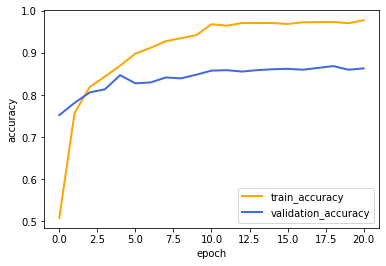

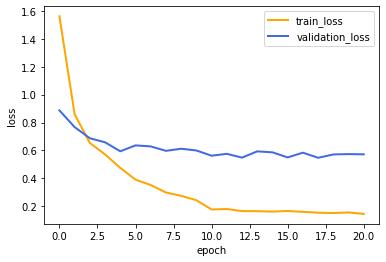

In [56]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],c='orange',linewidth=2) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy'],c='royalblue',linewidth=2) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'],c='orange',linewidth=2)
    plt.plot(history.history['val_loss'],c='royalblue',linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history)
plot_loss(history)

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

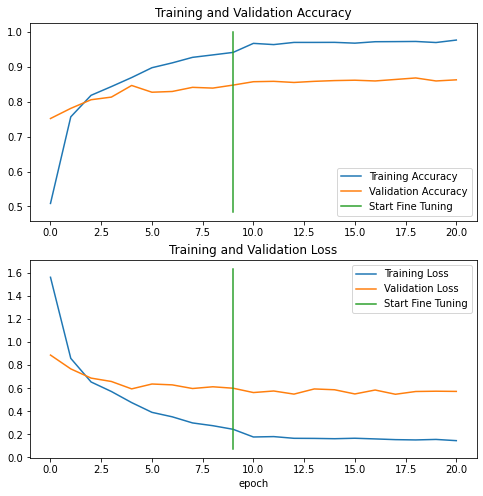

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **fine Tuning**

In [38]:
n_classes = 10
num_epochs = 10
fine_tune_epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files

In [32]:
K.clear_session()

img_width, img_height = 128, 128
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
batch_size = 16
bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
history_path = 'history_'+str(n_classes)+'.log'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.125,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')


validation_generator = train_datagen.flow_from_directory(
  train_data_dir, # same directory as training data
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode='categorical',
  subset='validation') # set as validation data

denseNet = DenseNet121(weights='imagenet',include_top=False)
x = denseNet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
model = Model(inputs=denseNet.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
csv_logger = CSVLogger(history_path)

history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

Found 6570 images belonging to 10 classes.
Found 930 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
410/410 [==============================] - ETA: 0s - loss: 2.2669 - accuracy: 0.2405
Epoch 00001: val_loss improved from inf to 1.83302, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 146s 315ms/step - loss: 2.2669 - accuracy: 0.2405 - val_loss: 1.8330 - val_accuracy: 0.4666
Epoch 2/10
410/410 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.5163
Epoch 00002: val_loss improved from 1.83302 to 1.25021, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 97s 237ms/step - loss: 1.5837 - accuracy: 0.5163 - val_loss: 1.2502 - val_accuracy: 0.6412
Epoch 3/10
410/410 [==============================] - ETA: 0s - loss: 1.1877 - accuracy: 0.6477
Epoch 00003: val_loss improved from 1.25021 to 0.99234, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 96s 234ms/step - loss: 1.1877 - accuracy: 0.6477 - val_loss: 0.9923 - val_accuracy: 0.7274
Epoch 4/10
410/410 [========

In [33]:
img_width, img_height = 128, 128
validation_data_dir = 'food-101/test_mini'
batch_size=16

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2500 images belonging to 10 classes.


In [34]:
K.clear_session()
model_best = load_model('bestmodel_10class.hdf5',compile = False)
model_best.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model_best.evaluate(test_generator)

157/157 [==============================] - 21s 112ms/step - loss: 0.4742 - accuracy: 0.8796


[0.4742061495780945, 0.8795999884605408]

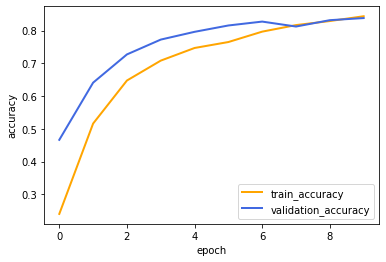

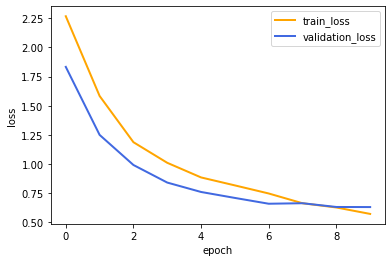

In [36]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],c='orange',linewidth=2) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy'],c='royalblue',linewidth=2) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'],c='orange',linewidth=2)
    plt.plot(history.history['val_loss'],c='royalblue',linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history)
plot_loss(history)

In [39]:
denseNet.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(denseNet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in denseNet.layers[:fine_tune_at]:
  layer.trainable =  False

total_epochs =  num_epochs + fine_tune_epochs

model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    callbacks=[csv_logger, checkpoint])

model.save(trainedmodel_path)

Number of layers in the base model:  427


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 10/20
410/410 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.8666
Epoch 00010: val_loss improved from 0.63186 to 0.59858, saving model to bestmodel_10class.hdf5
410/410 [==============================] - 91s 198ms/step - loss: 0.5075 - accuracy: 0.8666 - val_loss: 0.5986 - val_accuracy: 0.8491
Epoch 11/20
410/410 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.8697
Epoch 00011: val_loss did not improve from 0.59858
410/410 [==============================] - 79s 192ms/step - loss: 0.5089 - accuracy: 0.8697 - val_loss: 0.6256 - val_accuracy: 0.8319
Epoch 12/20
410/410 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8744
Epoch 00012: val_loss did not improve from 0.59858
410/410 [==============================] - 85s 206ms/step - loss: 0.5049 - accuracy: 0.8744 - val_loss: 0.6345 - val_accuracy: 0.8233
Epoch 13/20
410/410 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8702
Epoch 00013: 

In [43]:
K.clear_session()
model_best = load_model('bestmodel_10class.hdf5',compile = False)
model_best.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model_best.evaluate(test_generator)

157/157 [==============================] - 19s 97ms/step - loss: 0.4815 - accuracy: 0.8788


[0.4815438985824585, 0.8787999749183655]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

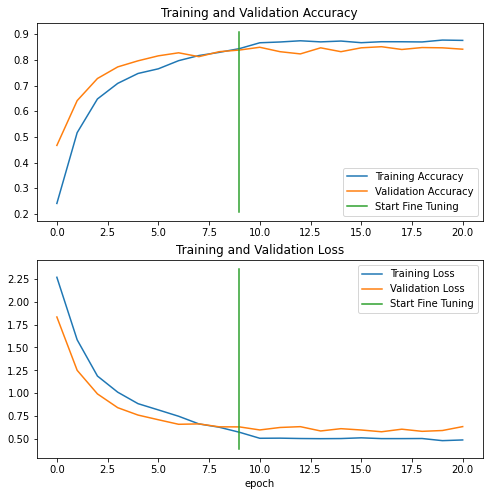

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()